<a href="https://colab.research.google.com/github/sizhky/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter11/simple_auto_encoder_with_different_latent_size.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q torch_snippets
from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms
device = 'cuda' if torch.cuda.is_available() else 'cpu'

     |████████████████████████████████| 61kB 3.4MB/s 
     |████████████████████████████████| 36.7MB 82kB/s 
     |████████████████████████████████| 102kB 12.5MB/s 


In [ ]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Lambda(lambda x: x.to(device))
])

In [ ]:
trn_ds = MNIST('/content/', transform=img_transform, train=True, download=True)
val_ds = MNIST('/content/', transform=img_transform, train=False, download=True)

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw


Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw


Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw




Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
batch_size = 256
trn_dl = DataLoader(trn_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latend_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), nn.ReLU(True),
            nn.Linear(128, 64), nn.ReLU(True), 
            #nn.Linear(64, 12),  nn.ReLU(True), 
            nn.Linear(64, latent_dim))
        self.decoder = nn.Sequential(
            #nn.Linear(latent_dim, 12), nn.ReLU(True),
            nn.Linear(latent_dim, 64), nn.ReLU(True),
            nn.Linear(64, 128), nn.ReLU(True), 
            nn.Linear(128, 28 * 28), nn.Tanh())

    def forward(self, x):
        x = x.view(len(x), -1)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(len(x), 1, 28, 28)
        return x

In [ ]:
!pip install torch_summary
from torchsummary import summary
model = AutoEncoder(3).to(device)
summary(model, torch.zeros(2,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3]                   --
|    └─Linear: 2-1                       [-1, 128]                 100,480
|    └─ReLU: 2-2                         [-1, 128]                 --
|    └─Linear: 2-3                       [-1, 64]                  8,256
|    └─ReLU: 2-4                         [-1, 64]                  --
|    └─Linear: 2-5                       [-1, 3]                   195
├─Sequential: 1-2                        [-1, 784]                 --
|    └─Linear: 2-6                       [-1, 64]                  256
|    └─ReLU: 2-7                         [-1, 64]                  --
|    └─Linear: 2-8                       [-1, 128]                 8,320
|    └─ReLU: 2-9                         [-1, 128]                 --
|    └─Linear: 2-10                      [-1, 784]                 101,136
|    └─Tanh: 2-11                        [-1, 784]                 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3]                   --
|    └─Linear: 2-1                       [-1, 128]                 100,480
|    └─ReLU: 2-2                         [-1, 128]                 --
|    └─Linear: 2-3                       [-1, 64]                  8,256
|    └─ReLU: 2-4                         [-1, 64]                  --
|    └─Linear: 2-5                       [-1, 3]                   195
├─Sequential: 1-2                        [-1, 784]                 --
|    └─Linear: 2-6                       [-1, 64]                  256
|    └─ReLU: 2-7                         [-1, 64]                  --
|    └─Linear: 2-8                       [-1, 128]                 8,320
|    └─ReLU: 2-9                         [-1, 128]                 --
|    └─Linear: 2-10                      [-1, 784]                 101,136
|    └─Tanh: 2-11                        [-1, 784]                 

In [ ]:
def train_batch(input, model, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output, input)
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def validate_batch(input, model, criterion):
    model.eval()
    output = model(input)
    loss = criterion(output, input)
    return loss

EPOCH: 1.000	trn_loss: 0.255	val_loss: 0.188	(15.16s - 60.63s remaining)
EPOCH: 2.000	trn_loss: 0.173	val_loss: 0.164	(29.95s - 44.93s remaining)
EPOCH: 3.000	trn_loss: 0.160	val_loss: 0.157	(44.96s - 29.97s remaining)
EPOCH: 4.000	trn_loss: 0.154	val_loss: 0.151	(60.01s - 15.00s remaining)
EPOCH: 5.000	trn_loss: 0.149	val_loss: 0.147	(74.98s - 0.00s remaining)


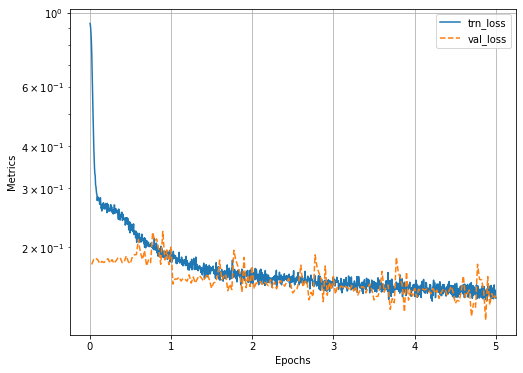

In [ ]:
model = AutoEncoder(3).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

num_epochs = 5
log = Report(num_epochs)

for epoch in range(num_epochs):
    N = len(trn_dl)
    for ix, (data, _) in enumerate(trn_dl):
        loss = train_batch(data, model, criterion, optimizer)
        log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')

    N = len(val_dl)
    for ix, (data, _) in enumerate(val_dl):
        loss = validate_batch(data, model, criterion)
        log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')
    log.report_avgs(epoch+1)
log.plot(log=True)

EPOCH: 1.000	trn_loss: 0.242	val_loss: 0.137	(15.06s - 60.26s remaining)
EPOCH: 2.000	trn_loss: 0.115	val_loss: 0.100	(30.08s - 45.12s remaining)
EPOCH: 3.000	trn_loss: 0.093	val_loss: 0.085	(45.05s - 30.03s remaining)
EPOCH: 4.000	trn_loss: 0.082	val_loss: 0.076	(60.02s - 15.00s remaining)
EPOCH: 5.000	trn_loss: 0.074	val_loss: 0.068	(75.03s - 0.00s remaining)


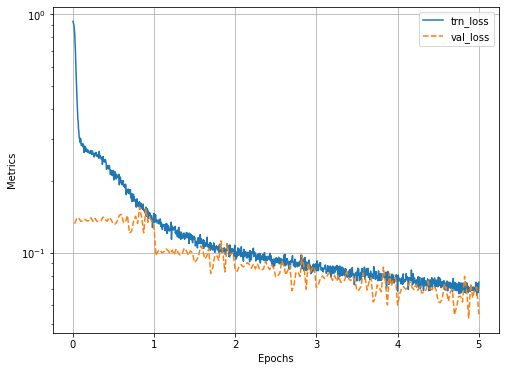

EPOCH: 1.000	trn_loss: 0.261	val_loss: 0.208	(15.08s - 60.31s remaining)
EPOCH: 2.000	trn_loss: 0.198	val_loss: 0.191	(30.24s - 45.36s remaining)
EPOCH: 3.000	trn_loss: 0.186	val_loss: 0.183	(45.33s - 30.22s remaining)
EPOCH: 4.000	trn_loss: 0.180	val_loss: 0.178	(60.34s - 15.09s remaining)
EPOCH: 5.000	trn_loss: 0.175	val_loss: 0.174	(75.43s - 0.00s remaining)


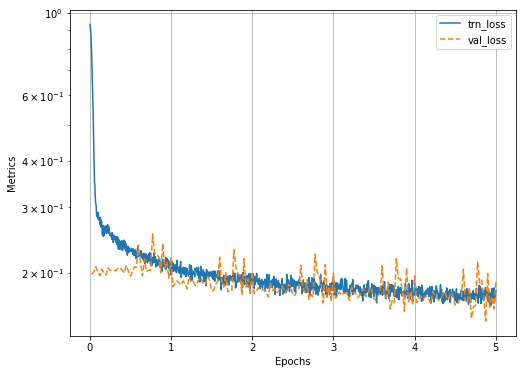

EPOCH: 1.000	trn_loss: 0.266	val_loss: 0.202	(15.04s - 60.15s remaining)
EPOCH: 2.000	trn_loss: 0.186	val_loss: 0.173	(30.25s - 45.38s remaining)
EPOCH: 3.000	trn_loss: 0.166	val_loss: 0.161	(45.26s - 30.17s remaining)
EPOCH: 4.000	trn_loss: 0.157	val_loss: 0.154	(60.22s - 15.06s remaining)
EPOCH: 5.000	trn_loss: 0.152	val_loss: 0.150	(75.17s - 0.00s remaining)


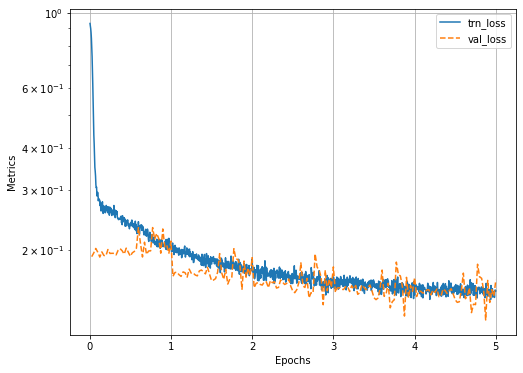

EPOCH: 1.000	trn_loss: 0.245	val_loss: 0.160	(14.92s - 59.67s remaining)
EPOCH: 2.000	trn_loss: 0.147	val_loss: 0.136	(29.98s - 44.97s remaining)
EPOCH: 3.000	trn_loss: 0.131	val_loss: 0.127	(45.04s - 30.03s remaining)
EPOCH: 4.000	trn_loss: 0.124	val_loss: 0.122	(60.39s - 15.10s remaining)
EPOCH: 5.000	trn_loss: 0.120	val_loss: 0.118	(75.35s - 0.00s remaining)


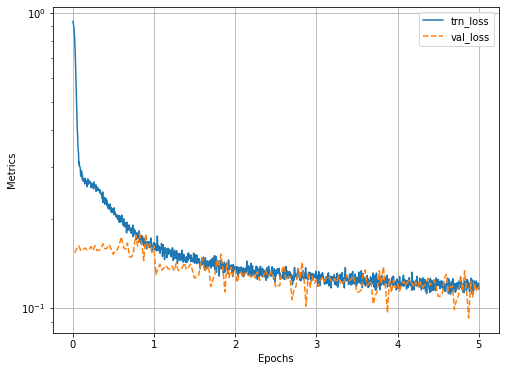

EPOCH: 1.000	trn_loss: 0.237	val_loss: 0.143	(15.06s - 60.25s remaining)
EPOCH: 2.000	trn_loss: 0.125	val_loss: 0.111	(30.00s - 45.00s remaining)
EPOCH: 3.000	trn_loss: 0.105	val_loss: 0.100	(45.06s - 30.04s remaining)
EPOCH: 4.000	trn_loss: 0.098	val_loss: 0.094	(60.02s - 15.01s remaining)
EPOCH: 5.000	trn_loss: 0.093	val_loss: 0.090	(74.95s - 0.00s remaining)


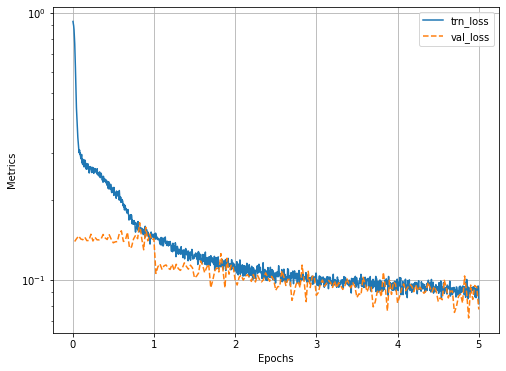

In [ ]:
def train_aec(latent_dim):
    model = AutoEncoder(latent_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

    num_epochs = 5
    log = Report(num_epochs)

    for epoch in range(num_epochs):
        N = len(trn_dl)
        for ix, (data, _) in enumerate(trn_dl):
            loss = train_batch(data, model, criterion, optimizer)
            log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')

        N = len(val_dl)
        for ix, (data, _) in enumerate(val_dl):
            loss = validate_batch(data, model, criterion)
            log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')
        log.report_avgs(epoch+1)
    log.plot(log=True)
    return model

aecs = [train_aec(dim) for dim in [50, 2, 3, 5, 10]]

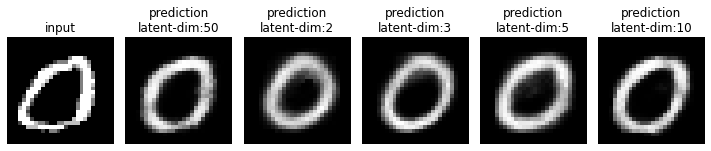

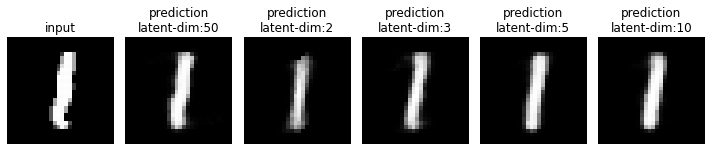

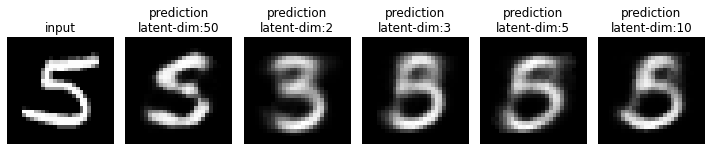

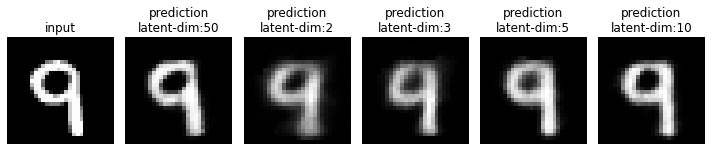

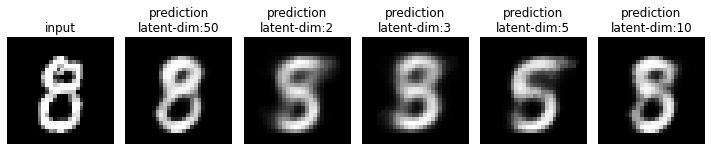

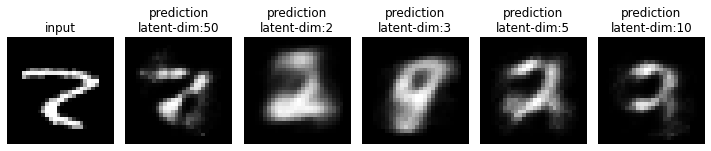

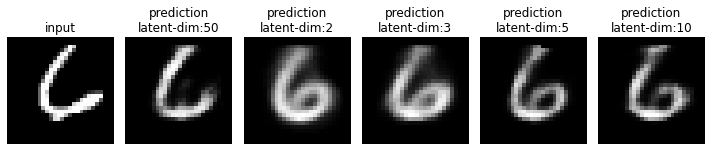

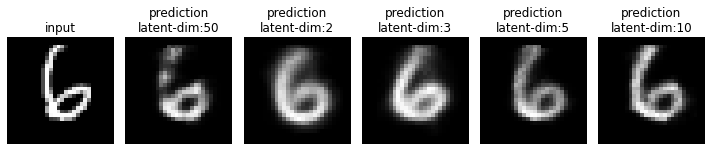

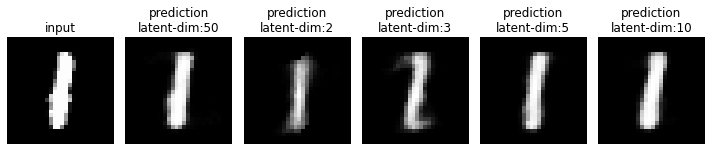

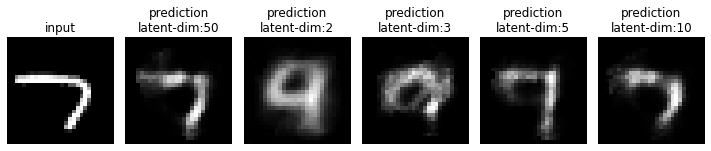

In [ ]:
for _ in range(10):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    fig, ax = plt.subplots(1, len(aecs)+1, figsize=(10,4))
    ax = iter(ax.flat)
    show(im[0], ax=next(ax), title='input')
    for model in aecs:
        _im = model(im[None])[0]
        show(_im[0], ax=next(ax), title=f'prediction\nlatent-dim:{model.latend_dim}')
    plt.tight_layout()
    plt.show()